## Generate Names using Bigram Model

In [2]:
# load name samples
names = open("names.txt", 'r').read().splitlines()
chars = set(''.join(names))
print(len(chars))
print(names[:5])
print(len(names))

26
['emma', 'olivia', 'ava', 'isabella', 'sophia']
32033


In [3]:
# count two characters occurance
counter = {}
for name in names:
    chars_list = ['<S>'] + list(name) + ['<E>']
    for char1, char2 in zip(chars_list, chars_list[1:]):
        pair = (char1, char2)
        counter[pair] = counter.get(pair, 0) + 1

In [4]:
import torch

new_chars = ['*'] + sorted(list(chars))
print(new_chars)

nchars = len(new_chars) # counting start and end token as 1 char


['*', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [5]:
char_index = {c:i for i, c in enumerate(new_chars)}
itochar = {i:c for i, c in enumerate(new_chars)}

In [6]:
N = torch.ones((nchars, nchars),  dtype=torch.int32) # using 1 to prevent infinity loss 
print(N.shape)

for name in names:
    char_list = ['*'] + list(name) + ['*']
    for char1, char2 in zip(char_list, char_list[1:]):
        idx1 = char_index[char1]
        idx2 = char_index[char2]
        N[idx1, idx2] += 1

torch.Size([27, 27])


In [7]:
N[0]

tensor([   1, 4411, 1307, 1543, 1691, 1532,  418,  670,  875,  592, 2423, 2964,
        1573, 2539, 1147,  395,  516,   93, 1640, 2056, 1309,   79,  377,  308,
         135,  536,  930], dtype=torch.int32)

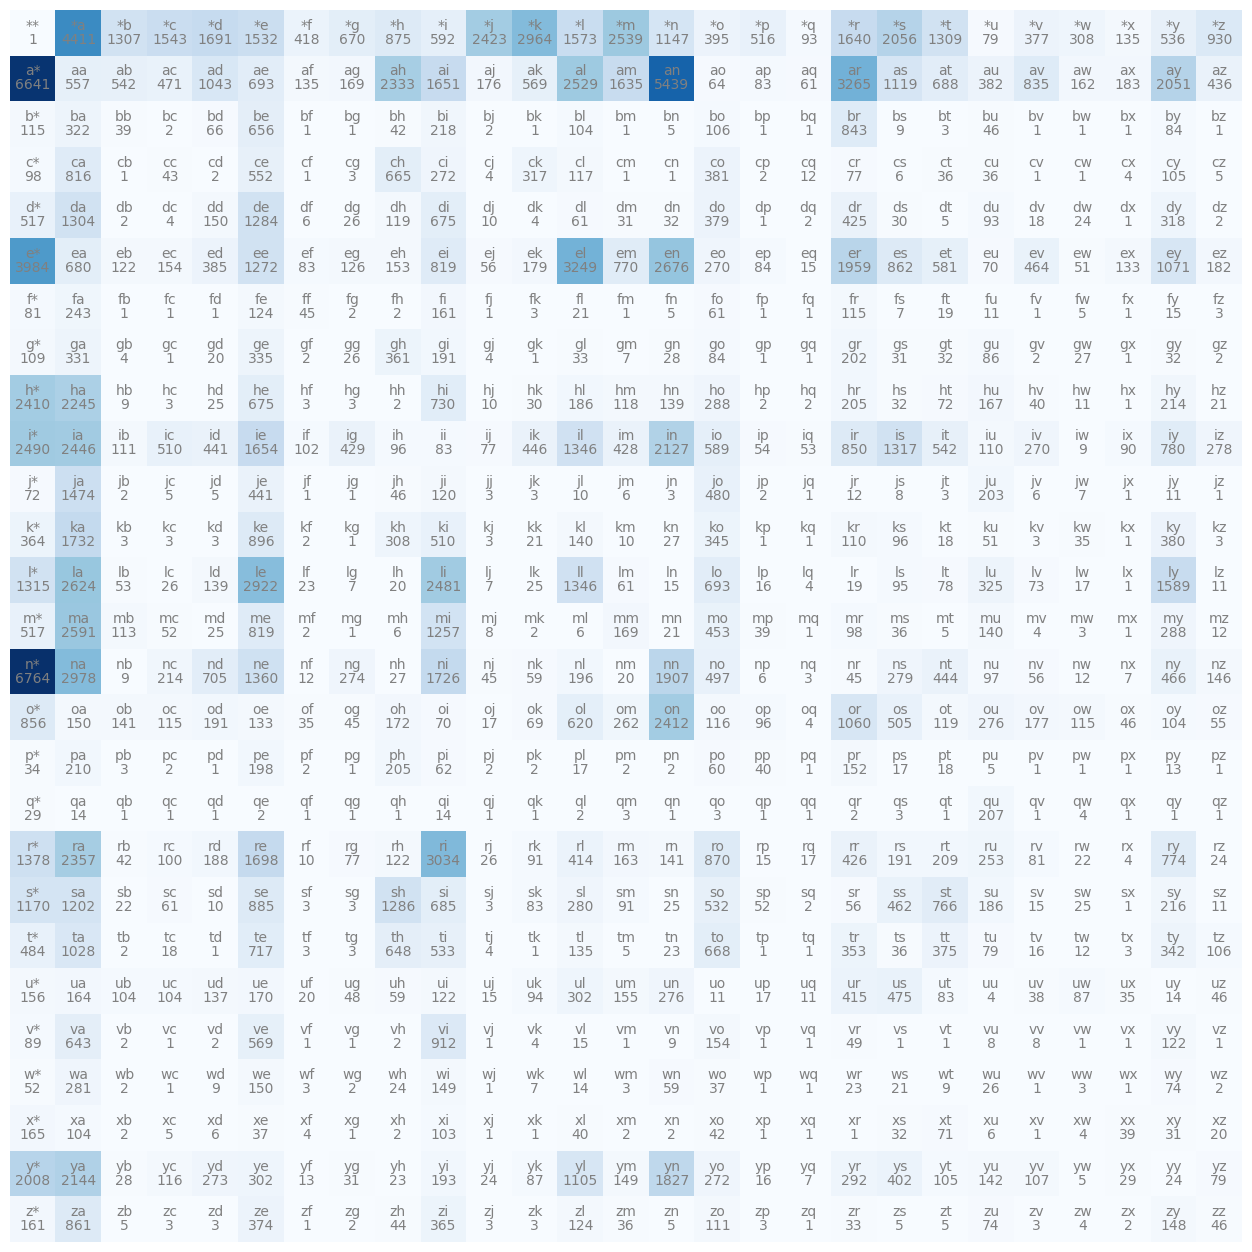

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(nchars):
    for j in range(nchars):

        chstr = itochar[i] + itochar[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [9]:
p = N[0].float()
p

tensor([1.0000e+00, 4.4110e+03, 1.3070e+03, 1.5430e+03, 1.6910e+03, 1.5320e+03,
        4.1800e+02, 6.7000e+02, 8.7500e+02, 5.9200e+02, 2.4230e+03, 2.9640e+03,
        1.5730e+03, 2.5390e+03, 1.1470e+03, 3.9500e+02, 5.1600e+02, 9.3000e+01,
        1.6400e+03, 2.0560e+03, 1.3090e+03, 7.9000e+01, 3.7700e+02, 3.0800e+02,
        1.3500e+02, 5.3600e+02, 9.3000e+02])

In [10]:
p = p/p.sum()
p.sum()

tensor(1.)

In [11]:
p.sum()

tensor(1.)

In [12]:
g = torch.Generator().manual_seed(21474836474)
ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
print(ix)

10


In [13]:
# normalize the occurance
P = N.float()
P /= P.sum(1, keepdims=True)
P.shape

torch.Size([27, 27])

In [14]:
g = torch.Generator().manual_seed(21474836410)

new_name = ""
idx = 0
while True:
    p = P[idx]
    idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()

    if idx == 0:
        break
    new_name += itochar[idx]

print(new_name)
    

glolylyaay


In [15]:
# This P will be our targeted next char prediction probability distribution to train neural network model
# Now take a look at our desired loss value
log_likelihood = 0
n = 0
for name in names:
    for char1, char2 in zip(name, name[1:]):
        idx1, idx2 = char_index[char1], char_index[char2]
        prob = P[idx1, idx2]
        # using log to perform addition instead of massive production operations
        log_likelihood += torch.log(prob)
        n += 1
print(log_likelihood)
print(-log_likelihood / n)

tensor(-412482.3750)
tensor(2.5139)


In [73]:
# creating a training dataset
xs, ys = [], []
for name in names[:1]:
    chs = ["*"] + list(name) + ["*"]
    for char1, char2 in zip(chs, chs[1:]):
        idx1, idx2 = char_index[char1], char_index[char2]
        xs.append(idx1)
        ys.append(idx2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs, ys)

tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


In [74]:
import torch.nn.functional as F

encoded_input = F.one_hot(xs, num_classes=27).float()
print(encoded_input.shape)
encoded_input

torch.Size([5, 27])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [75]:
# initialize random weights for neural network
W = torch.randn((27, 27), requires_grad=True)

In [76]:
# perform matrix multiplication on input using weight matrix
output = encoded_input @ W
output

tensor([[-6.4762e-01,  2.7126e-01, -8.3035e-01,  3.7196e-03,  1.1433e+00,
         -5.2999e-01,  2.0496e+00,  1.5675e-01, -1.8961e+00,  2.7560e+00,
         -9.0191e-02, -2.1723e+00, -7.0380e-02, -1.7736e-01, -7.8486e-01,
          1.8542e+00,  2.7169e-01, -9.7361e-01, -1.4391e+00,  1.3429e-01,
          1.1702e+00,  5.6726e-01,  1.7604e+00,  4.8540e-01,  2.5621e+00,
         -3.1096e-01, -6.4570e-01],
        [ 1.1079e+00,  3.6621e-01, -7.7872e-01,  1.9282e-01,  7.4765e-01,
         -1.7303e-05,  1.0640e+00, -1.2454e-02, -1.6824e+00, -9.7941e-01,
         -1.5639e-01,  1.6397e-01, -3.1308e-01, -6.3056e-01,  5.4486e-01,
          7.2461e-02,  1.6335e-01,  9.1757e-01, -2.0116e-01,  1.0458e+00,
          5.9006e-01, -8.4706e-01,  2.7106e-01, -5.0897e-01,  8.9020e-01,
          1.6014e+00, -8.6079e-01],
        [-9.6306e-01, -4.9184e-01,  1.1729e+00,  5.5750e-01, -4.3774e-01,
         -5.0006e-01,  7.5882e-02,  9.8235e-01,  2.5262e-01,  5.8663e-01,
          8.0238e-01,  2.0494e+00,  1.91

In [77]:
# pass output to softmax to generate probabilities for each class

exp = output.exp()
print(exp.shape)
exp

torch.Size([5, 27])


tensor([[ 0.5233,  1.3116,  0.4359,  1.0037,  3.1370,  0.5886,  7.7647,  1.1697,
          0.1501, 15.7366,  0.9138,  0.1139,  0.9320,  0.8375,  0.4562,  6.3867,
          1.3122,  0.3777,  0.2371,  1.1437,  3.2226,  1.7634,  5.8148,  1.6248,
         12.9634,  0.7327,  0.5243],
        [ 3.0280,  1.4423,  0.4590,  1.2127,  2.1120,  1.0000,  2.8979,  0.9876,
          0.1859,  0.3755,  0.8552,  1.1782,  0.7312,  0.5323,  1.7244,  1.0752,
          1.1774,  2.5032,  0.8178,  2.8457,  1.8041,  0.4287,  1.3114,  0.6011,
          2.4356,  4.9598,  0.4228],
        [ 0.3817,  0.6115,  3.2315,  1.7463,  0.6455,  0.6065,  1.0788,  2.6707,
          1.2874,  1.7979,  2.2308,  7.7636,  6.7755,  1.0184,  3.1739,  0.1168,
          0.6207,  0.3763,  8.0913,  0.4831,  0.6402,  7.1176, 10.7087,  2.6129,
          1.1477,  3.0976,  0.3431],
        [ 0.3817,  0.6115,  3.2315,  1.7463,  0.6455,  0.6065,  1.0788,  2.6707,
          1.2874,  1.7979,  2.2308,  7.7636,  6.7755,  1.0184,  3.1739,  0.1168

In [78]:
probs = exp / exp.sum(1, keepdims=True)
print(probs.shape)
probs

torch.Size([5, 27])


tensor([[0.0074, 0.0184, 0.0061, 0.0141, 0.0441, 0.0083, 0.1091, 0.0164, 0.0021,
         0.2211, 0.0128, 0.0016, 0.0131, 0.0118, 0.0064, 0.0897, 0.0184, 0.0053,
         0.0033, 0.0161, 0.0453, 0.0248, 0.0817, 0.0228, 0.1821, 0.0103, 0.0074],
        [0.0774, 0.0369, 0.0117, 0.0310, 0.0540, 0.0256, 0.0741, 0.0253, 0.0048,
         0.0096, 0.0219, 0.0301, 0.0187, 0.0136, 0.0441, 0.0275, 0.0301, 0.0640,
         0.0209, 0.0728, 0.0461, 0.0110, 0.0335, 0.0154, 0.0623, 0.1268, 0.0108],
        [0.0054, 0.0087, 0.0459, 0.0248, 0.0092, 0.0086, 0.0153, 0.0379, 0.0183,
         0.0255, 0.0317, 0.1103, 0.0963, 0.0145, 0.0451, 0.0017, 0.0088, 0.0053,
         0.1150, 0.0069, 0.0091, 0.1011, 0.1522, 0.0371, 0.0163, 0.0440, 0.0049],
        [0.0054, 0.0087, 0.0459, 0.0248, 0.0092, 0.0086, 0.0153, 0.0379, 0.0183,
         0.0255, 0.0317, 0.1103, 0.0963, 0.0145, 0.0451, 0.0017, 0.0088, 0.0053,
         0.1150, 0.0069, 0.0091, 0.1011, 0.1522, 0.0371, 0.0163, 0.0440, 0.0049],
        [0.0098, 0.0261,

In [79]:
"""
loss value calculation:
1. allocate probabilities for labeled next char prediction
2. compute log of all these probabilities
3. compute mean value of all the log probs
"""
loss = -probs[torch.arange(xs.nelement()), ys].log().mean()
loss.item()

4.540377616882324

In [80]:
# perform gradient descent on training
from tqdm import tqdm

epochs = 2
learning_rate = 0.1
for e in range(epochs):
    loss_avg = 0
    for name in tqdm(names):
        char_list = ['*'] + list(name) + ['*']
        xs, ys = [], []
        for char1, char2 in zip(char_list, char_list[1:]):
            idx1 = char_index[char1]
            idx2 = char_index[char2]
            xs.append(idx1)
            ys.append(idx2)

        xs, ys = torch.tensor(xs), torch.tensor(ys)
        encoded_input = F.one_hot(xs, num_classes=27).float()
        # forward pass
        output = encoded_input @ W
        logits = output.exp()
        probs = logits / logits.sum(1, keepdims=True)
        loss = -probs[torch.arange(xs.nelement()), ys].log().mean() + 0.01 *(W**2).mean()
        loss_avg += loss.item()
        W.grad = None # set to zero the gradient
        loss.backward()

        W.data += - learning_rate * W.grad
    loss_avg = loss_avg / len(names)
    print(f"mean average loss = {loss_avg}")

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32033/32033 [00:02<00:00, 12357.41it/s]


mean average loss = 2.580782113090738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32033/32033 [00:02<00:00, 12526.35it/s]

mean average loss = 2.4636773673846415


In [86]:
# Now use trained weight to generate new names
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
    idx = 0
    new_name = ""
    while True:
        encoded_input = F.one_hot(torch.tensor([idx]), num_classes=27).float()
        output = encoded_input @ W
        logits = output.exp()
        probs = logits / logits.sum(1, keepdims=True)
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if idx == 0:
            break
        new_name += itochar[idx]
    print(new_name)

cexze
loglsurkroczktyhnerlnlmjtna
nrlknak
ka



In [85]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itochar[ix])
    if ix == 0:
      break
  print(''.join(out))

mellan*
hee*
dvambi*
sezean*
qlliai*
